In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy.stats import shapiro, probplot
from sklearn import metrics
from sklearn.dummy import DummyClassifier
# from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# import datawig

/Users/wolfrieder/miniconda3/envs/code/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [12]:
data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/train_set_01.parquet.gzip"
)

data_test = pd.read_parquet('../data/processed/firefox/08_12_2022/test_set.parquet.gzip')

In [15]:
empty_columns = [col for col in data if data[col].isnull().all() == True]
data.drop(empty_columns, axis=1, inplace=True)

In [26]:
columns = empty_columns + data_test.columns.values.tolist()

In [28]:
empty_columns = ([x for x in columns if columns.count(x) > 1])

In [31]:
data_test.drop(empty_columns, axis=1, inplace=True)

In [116]:
firefox_columns = data_test.columns.values.tolist()
chrome_columns = data.columns.values.tolist()

In [41]:
cols_not_in_chrome = list(set(firefox_columns).difference(chrome_columns))

In [43]:
data_test.drop(cols_not_in_chrome, axis=1, inplace=True)

In [48]:
list(set(chrome_columns).difference(firefox_columns))

['front',
 'x-rh-edge-cache-status',
 'queryhash',
 'x-imbo-imagevariation',
 'x-returned-forwarded-entry-proto',
 'x-system',
 'x-accelerating',
 'arrserver',
 'x-uncompressed-size',
 'x-lpb-version',
 'x-apw-social',
 'scg',
 'x-remoteip',
 'x-fpc',
 'x-proxy-scache',
 'x-mobile-tovima-loginview-hashed-on',
 'x-orig-src',
 'x-lat',
 'vnd-eo-span-id',
 'x-apw-authorization-denied',
 'x-queue-time',
 'x-amz-meta-aspera.transfer',
 'x-yandex-items-count',
 'x-apw-oac-pids',
 'x-tanea2013-poll-id',
 'no-retry',
 'x-rsrc',
 'content-origin',
 'x-article-cache',
 'x-spotx-exception-conf-id',
 'x-redhat-debug',
 'uip-status',
 'branch',
 'ot-requestid',
 'x-cmp-answers',
 'x-applogic',
 'x-io',
 'x-server-epoch',
 'x-hayabusa-cf-cachekey',
 'x-gateway-route',
 'x-nodeip',
 'rate-limit',
 'x-amz-meta-mutable',
 'x-isvalidated',
 'x-dv-response',
 'x-apw-access-action',
 'incap-client-ip',
 'x-mrs-cache',
 'x-obvious-info',
 'x-highwire-smart-code',
 'x-tableau-cf-response-time',
 'x-renderin

In [52]:
from rapidfuzz import process


def new_fuzzy_string_matching_for_column(col_name, col_values):
    fuzzy_result = pd.DataFrame(
        process.extract(
            col_name, col_values, processor=None, score_cutoff=80, limit=100
        ),
        columns=["fuzzy_match", "w_ratio", "index"],
    )
    fuzzy_result["col_name"] = col_name
    return fuzzy_result

In [56]:
data_column_values = data.columns.values[6:-1].tolist()
match = [
    new_fuzzy_string_matching_for_column(j, data_column_values[i + 1:])
    for i, j in enumerate(data_column_values)
    if i != len(data_column_values) - 1
]

match2 = pd.concat(match, ignore_index=True)
del match

In [58]:
def find_cols_with_similar_values(fuzzy_match, column):
    value_fuzzy = set(data[fuzzy_match].values)
    value_column = set(data[column].values)

    try:
        value_fuzzy.remove(None)
        value_column.remove(None)
    except KeyError:
        pass

    if (len([True for i in value_fuzzy if i in value_column]) / len(value_fuzzy)) > 0.5:
        return fuzzy_match, column
    else:
        return None

In [59]:
result = [
    find_cols_with_similar_values(col, col2)
    for col, col2 in zip(match2["fuzzy_match"], match2["col_name"])
]

In [61]:
def select_similar_columns(fuzzy_match, column):
    row = match2.loc[
        (match2["fuzzy_match"] == fuzzy_match) & (match2["col_name"] == column)
        ]
    index = row.index[0]
    match2.drop(index, inplace=True)
    return row


similar_values = [
    select_similar_columns(col[0], col[1]) for col in result if col is not None
]

similar_values_test = pd.concat(similar_values, ignore_index=True)
similar_values = pd.concat(similar_values, ignore_index=True)

In [71]:
values = list(set(similar_values.col_name.values.tolist() + similar_values.fuzzy_match.values.tolist()))

In [74]:
cols_not_in_firefox = list(set(values).difference(firefox_columns))

In [83]:
similar_values_test = similar_values_test[~similar_values_test['fuzzy_match'].isin(cols_not_in_firefox)]

In [85]:
similar_values_test = similar_values_test[~similar_values_test['col_name'].isin(cols_not_in_firefox)]

In [88]:
def merge_similar_columns2(fuzzy_match, col_name):
    boolean_mask = data[fuzzy_match].notnull()
    new_values = data[boolean_mask][fuzzy_match].to_numpy()
    indices_fuzzy_matches = data.index[boolean_mask].tolist()

    current_values = data[col_name].to_numpy()
    np.put(current_values, indices_fuzzy_matches, new_values)


data.reset_index(drop=True, inplace=True)
similar_values.apply(
    lambda x: merge_similar_columns2(x["fuzzy_match"], x["col_name"]), axis=1
)

0       None
1       None
2       None
3       None
4       None
        ... 
1634    None
1635    None
1636    None
1637    None
1638    None
Length: 1639, dtype: object

In [90]:
def merge_similar_columns2_test(fuzzy_match, col_name):
    boolean_mask = data_test[fuzzy_match].notnull()
    new_values = data_test[boolean_mask][fuzzy_match].to_numpy()
    indices_fuzzy_matches = data_test.index[boolean_mask].tolist()

    current_values = data_test[col_name].to_numpy()
    np.put(current_values, indices_fuzzy_matches, new_values)


similar_values_test.apply(
    lambda x: merge_similar_columns2_test(x["fuzzy_match"], x["col_name"]),
    axis=1,
)

1       None
2       None
3       None
4       None
5       None
        ... 
1634    None
1635    None
1636    None
1637    None
1638    None
Length: 1488, dtype: object

In [91]:
columns_to_remove = list(set(similar_values.fuzzy_match.values.tolist()))
data.drop(columns_to_remove, axis=1, inplace=True)

In [92]:
columns_to_remove = list(set(similar_values_test.fuzzy_match.values.tolist()))
data_test.drop(columns_to_remove, axis=1, inplace=True)

In [101]:
def test_new_categories_update(element, dataset):
    categories = dataset[element].astype("category").cat.categories.values.tolist()
    try:
        np.array(categories, dtype="int64")
        return {element: "Int64"}
    except (ValueError, OverflowError):
        return None


def create_categories_list(dataset):
    dtype_list = {i: "category" for i in dataset.columns.values[:-1]}
    current_columns = dataset.columns.values[6:-1].tolist()
    int64_columns = [
        test_new_categories_update(element, dataset) for element in current_columns
    ]

    int64_columns = list(filter(lambda x: type(x) is dict, int64_columns))
    int64_columns = {k: v for d in int64_columns for k, v in d.items()}

    dtype_list.update(int64_columns)
    del dtype_list["query"]
    del dtype_list["protocol"]
    return dtype_list

In [102]:
list_of_dtypes = create_categories_list(data)
list_of_dtypes_test = create_categories_list(data_test)
data.drop(["protocol", "query"], axis=1, inplace=True)
data_test.drop(["protocol", "query"], axis=1, inplace=True)
data = data.astype(list_of_dtypes)
data_test = data_test.astype(list_of_dtypes_test)

In [110]:
def reduced_variance_per_column(column):
    unique_values = int(len(set(data[column]))) - 1
    na_values = data[column].isna().sum()
    return [column, unique_values, round(na_values / len(data), 3)]


number_of_elements = np.array(
    [
        reduced_variance_per_column(column)
        for column in data.iloc[:, 4:-2].columns
    ]
)

In [112]:
summary_table = pd.DataFrame(
    number_of_elements, columns=["header_name", "unique_values", "na_ratio"]
)
summary_table["unique_values"] = summary_table["unique_values"].astype("Int32")
summary_table["na_ratio"] = summary_table["na_ratio"].astype("float32")
remove_headers_with_one_na_ratio = summary_table[
    summary_table["na_ratio"] == 1
    ].header_name.values.tolist()
remove_headers_with_one_value = summary_table[
    (summary_table["unique_values"] <= 1) & (summary_table["na_ratio"] != 1)
    ].header_name.values.tolist()

In [ ]:
data.drop(remove_headers_with_one_na_ratio, axis=1, inplace=True)
data.drop(remove_headers_with_one_value, axis=1, inplace=True)

In [134]:
col_intersection = list(set(remove_headers_with_one_na_ratio).intersection(firefox_columns))

In [137]:
data_test.drop(col_intersection, axis=1, inplace=True)

In [138]:
firefox_columns = data_test.columns.values.tolist()
col_intersection = list(set(remove_headers_with_one_value).intersection(firefox_columns))

In [140]:
data_test.drop(col_intersection, axis=1, inplace=True)

In [158]:
def variance_per_column_2(column):
    tracker_ratio = data[data[column].notnull()].tracker.value_counts()
    try:
        trackers = tracker_ratio[1]
    except KeyError:
        trackers = 0
    try:
        non_trackers = tracker_ratio[0]
    except KeyError:
        non_trackers = 0
    return [column, trackers, non_trackers]


def create_summary_table(dataset):
    number_of_elements_reduced = np.array(
        [variance_per_column_2(column) for column in dataset.iloc[:, 4:-1].columns]
    )
    summary_table_2 = pd.DataFrame(
        number_of_elements_reduced, columns=["header_name", "trackers", "non_trackers"]
    )
    summary_table_2["trackers"] = summary_table_2["trackers"].astype("Int32")
    summary_table_2["non_trackers"] = summary_table_2["non_trackers"].astype("float32")
    summary_table_2["ratio"] = (
                                       summary_table_2["trackers"] / summary_table_2["non_trackers"]
                               ) * 100
    summary_table_2["ratio2"] = (
                                        summary_table_2["non_trackers"] / summary_table_2["trackers"]
                                ) * 100
    return summary_table_2


summary_table2 = create_summary_table(data)

In [163]:


def concise_information(col_list, classification, dataset):
    indices = list()

    for col in col_list:
        indices.append(
            dataset[
                (dataset[col].notnull()) & (dataset["tracker"] == classification)
                ].index.tolist()
        )

    return indices


def find_cols_to_combine(information_table):
    only_non_trackers = information_table[
        information_table["ratio"] <= 10
        ].header_name.values.tolist()
    only_trackers = information_table[
        information_table["ratio2"] <= 10
        ].header_name.values.tolist()
    return only_non_trackers, only_trackers


def concise_information_wrapper(dataset, table):
    only_non_tracker_cols, only_tracker_cols = find_cols_to_combine(table)

    dataset["comb_col_non_tracker"] = 0
    dataset["comb_col_tracker"] = 0

    col_tracker = dict(
        Counter(
            list(
                np.concatenate(concise_information(only_tracker_cols, 1, dataset)).flat
            )
        )
    )
    col_non_tracker = dict(
        Counter(
            list(
                np.concatenate(
                    concise_information(only_non_tracker_cols, 0, dataset)
                ).flat
            )
        )
    )

    for key, value in col_tracker.items():
        dataset.at[key, "comb_col_tracker"] = value

    for key, value in col_non_tracker.items():
        dataset.at[key, "comb_col_non_tracker"] = value


concise_information_wrapper(data, summary_table2)
# concise_information_wrapper(data_test, summary_table2)

In [165]:
data_copy = data_test.copy(deep=True)

In [175]:
firefox_summary_table = summary_table2[~summary_table2.header_name.isin(list(set(data.columns.values.tolist())
                                                                             .difference(
    data_test.columns.values.tolist())))]

concise_information_wrapper(data_test, firefox_summary_table)

In [176]:
only_non_tracker_col, only_tracker_col = find_cols_to_combine(summary_table2)

In [178]:
data.drop(only_non_tracker_col, axis=1, inplace=True)
data.drop(only_tracker_col, axis=1, inplace=True)

In [ ]:
a = ['edge-start', 'origin-latency', 'x-uniq-id', 'x-requestuuid', 'x-sbistracker', 'x-cdn-cache-id']

In [198]:
data_test.drop(list(set(only_non_tracker_col).difference(a)), axis=1, inplace=True)
data_test.drop(only_tracker_col, axis=1, inplace=True)

In [202]:
list(set(data_test.columns.values.tolist()).difference(data.columns.values.tolist()))

['cdn-name']

In [204]:
data_test.drop('cdn-name', axis=1, inplace=True)

In [205]:
data_test.to_parquet(
    "../data/processed/firefox/08_12_2022/test_set_01_processed.parquet.gzip",
    compression="gzip",
)

In [3]:
train_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/train_set_01_processed.parquet.gzip"
)
test_data = pd.read_parquet(
    "../data/processed/firefox/08_12_2022/test_set_01_processed.parquet.gzip"
)

In [8]:
train_data

,hostname,pathname,filetype,filename,pragma,content-type,last-modified,accept-ranges,etag,p3p,...,x-b3-sampled,x-b3-spanid,x-hubspot-correlation-id,x-hs-target-asset,x-hostname,x-cdn-pop,x-cdn-pop-ip,tracker,comb_col_non_tracker,comb_col_tracker
0,tpc.googlesyndication.com,/pagead/js/r20220810/r20110914/client/one_clic...,js,one_click_handler_one_afma_fy2021.js,NaN,text/javascript; charset=utf-8,NaN,NaN,15601544113783900868,"policyref=""https://www.googleadservices.com/pa...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
1,res.cdn.office.net,/officehub/bundles/staying-aware.b8b088b355c55...,js,staying-aware.b8b088b355c55b4ea7d6.chunk.v6.js,NaN,application/javascript,"mon, 08 aug 2022 21:56:59 gmt",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0
2,www.google.com,/ads/ga-audiences,/ads/ga-audiences,ga-audiences,no-cache,image/gif,NaN,NaN,NaN,"policyref=""https://www.googleadservices.com/pa...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
3,ipv4-c113-lhr004-ix.1.oca.nflxvideo.net,/speedtest/range/0-0,/speedtest/range/0-0,0-0,no-cache,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
4,shimo.im,/,/,,NaN,text/html; charset=utf-8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271999,www.criteo.com,/wp-content/uploads/2021/01/ss-logo-Lamps-Plus...,png,ss-logo-Lamps-Plus.png,NaN,image/png,"fri, 12 nov 2021 05:09:38 gmt",bytes,"""618df712-2509""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5,0
272000,ads.adfox.ru,/260122/event,/260122/event,event,no-cache,NaN,"fri, 12 aug 2022 09:22:13 gmt",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
272001,synostatic.synology.com,/font/inter/inter-w400-6.woff2,woff2,inter-w400-6.woff2,NaN,binary/octet-stream,"mon, 20 dec 2021 02:24:19 gmt",bytes,"""4abfa4888190370d347034f9fa43c804""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
272002,tenor.com,/opensearch.xml,xml,opensearch.xml,NaN,application/xml,"thu, 26 apr 2018 18:25:27 gmt",bytes,"w/""29a-1630333f5d8""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0


In [9]:
test_data

,hostname,pathname,filetype,filename,date,content-type,content-length,cache-control,content-disposition,etag,...,x-via-ssl,request-time,access-control-request-method,fss-proxy,x-dc,x-llid,x-b3-sampled,tracker,comb_col_non_tracker,comb_col_tracker
0,vuukle.com,/a3a95d10e1d03fe77d6b.png,png,a3a95d10e1d03fe77d6b.png,"fri, 12 aug 2022 22:10:52 gmt",image/webp,15780,"public, max-age=7200","inline; filename=""a3a95d10e1d03fe77d6b.webp""","""a76e19b58c5103936ca99a64e6c1d71d""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0
1,vuukle.com,/589.1b85456a4e062e8d6232.js,js,589.1b85456a4e062e8d6232.js,"fri, 12 aug 2022 22:10:52 gmt",application/javascript,1539,"public, max-age=7200",NaN,"w/""573591b2d822f76e9fa661dcdc83c284""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0
2,vuukle.com,/29eab20501ed73f16eba.jpg,jpg,29eab20501ed73f16eba.jpg,"fri, 12 aug 2022 22:10:52 gmt",image/webp,9952,"public, max-age=7200","inline; filename=""29eab20501ed73f16eba.webp""","""97fe776c2cbd2cbaa24192f89eaefc74""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0
3,vuukle.com,/22ab1ea08fc1962409f1.png,png,22ab1ea08fc1962409f1.png,"fri, 12 aug 2022 22:10:52 gmt",image/webp,41109,"public, max-age=7200","inline; filename=""22ab1ea08fc1962409f1.webp""","""6193272dc9caf2486c404218e1380542""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0
4,cookie-cdn.cookiepro.com,/scripttemplates/6.19.0/otTCF.js,js,otTCF.js,"fri, 12 aug 2022 22:10:52 gmt",application/javascript,<NA>,"public, max-age=14400",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498363,nt.global.ssl.fastly.net,/images/1431839055959-1428713.jpg,jpg,1431839055959-1428713.jpg,"fri, 12 aug 2022 17:28:58 gmt",image/webp,230,NaN,inline;filename=1428713.jpg;filename*=utf-8''1...,"""lp0kw1rx62w0lmnah1yusy/dyxtczm9x1svbssqydcu""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0
498364,region1.google-analytics.com,/g/collect,/g/collect,collect,"fri, 12 aug 2022 17:28:58 gmt",text/plain,0,"no-cache, no-store, must-revalidate",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
498365,region1.google-analytics.com,/g/collect,/g/collect,collect,"fri, 12 aug 2022 17:28:58 gmt",text/plain,0,"no-cache, no-store, must-revalidate",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
498366,nt.global.ssl.fastly.net,/images/1431846945741-petworthbeautiesbeautyro...,jpg,1431846945741-petworthbeautiesbeautyroom.jpg,"fri, 12 aug 2022 17:28:58 gmt",image/webp,206,NaN,inline;filename=petworthbeauties_beautyroom.jp...,"""a+x3kgq0g9qfmdlswkdp6yvat8wg4xh1vd6lv4reg+o""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0


In [7]:
train_data.drop('header_count', axis=1, inplace=True)

In [10]:
train_data = train_data.iloc[:, 4:]
test_data = test_data.iloc[:, 4:]

In [129]:
a = (
    train_data[train_data["content-length"].notnull()]["content-length"]
    .to_numpy()
    .astype(np.int64)
)

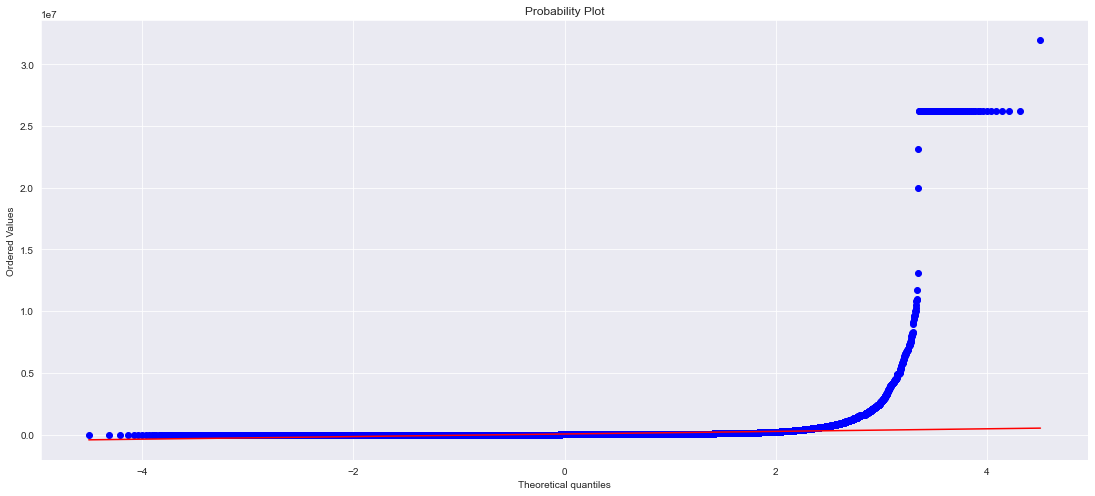

In [130]:
fig2 = plt.figure(figsize=(30, 7))
ax3 = fig2.add_subplot(1, 2, 1)
probplot(a, dist="norm", plot=ax3)
fig2.tight_layout()
plt.show()

In [6]:
def check_distribution(dataset, feature, distribution):
    values = dataset[dataset[feature].notnull()][feature]
    sample_size = {5001: 1067, 5000: 880, 2500: 748, 1000: 516, 500: 341, 200: 169}
    sample_values = [v for v in sample_size.keys() if len(values) > v]
    if len(sample_values) == 0:
        n = int(len(values) * 0.1)
    else:
        n = sample_size[sample_values[0]]
    feature_values = values.sample(n=n, random_state=10).to_numpy().astype(np.int64)
    stat, p_value = shapiro(feature_values)  # kstest(feature_values, 'norm')
    return stat, p_value

In [28]:
list_of_integer_cols = list(train_data.select_dtypes("Int64").columns.values.tolist())
list_of_float_cols = list(train_data.select_dtypes("Float64").columns.values.tolist())

In [23]:
list_of_integer_cols

['content-length',
 'x-robots-tag_binary',
 'connection_binary',
 'x-amz-server-side-encryption_binary',
 'x-amz-version-id_binary',
 'x-cache_binary',
 'via_binary',
 'x-amz-cf-pop_binary',
 'x-amz-cf-id_binary',
 'x-guploader-uploadid_binary',
 'x-goog-generation_binary',
 'x-goog-hash_binary',
 'x-goog-storage-class_binary',
 'cf-cache-status_binary',
 'expect-ct_binary',
 'report-to_binary',
 'nel_binary',
 'cf-ray_binary',
 'set-cookie_binary',
 'content-security-policy-report-only_binary',
 'access-control-expose-headers_binary',
 'access-control-allow-headers_binary',
 'access-control-max-age_binary',
 'x-powered-by_binary',
 'cross-origin-opener-policy-report-only_binary',
 'content-security-policy_binary',
 'cross-origin-opener-policy_binary',
 'x-frame-options_binary',
 'x-fb-debug_binary',
 'priority_binary',
 'x-amz-id-2_binary',
 'x-amz-request-id_binary',
 'access-control-allow-methods_binary',
 'x-served-by_binary',
 'edge-control_binary',
 'permissions-policy_binary',
 

In [13]:
train_data["comb_col_non_tracker"] = train_data["comb_col_non_tracker"].astype("uint8")
train_data["comb_col_tracker"] = train_data["comb_col_tracker"].astype("uint8")
train_data["header_count"] = train_data["header_count"].astype("uint8")
train_data["tracker"] = train_data["tracker"].astype("uint8")

In [14]:
test_data["comb_col_non_tracker"] = test_data["comb_col_non_tracker"].astype("uint8")
test_data["comb_col_tracker"] = test_data["comb_col_tracker"].astype("uint8")
test_data["header_count"] = test_data["header_count"].astype("uint8")
test_data["tracker"] = test_data["tracker"].astype("uint8")

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272004 entries, 0 to 272003
Columns: 153 entries, pragma to comb_col_tracker
dtypes: Int64(15), category(135), uint8(3)
memory usage: 114.5 MB


In [317]:
train_data["etag_length"].max()

214.0

In [136]:
for col in list_of_integer_cols:
    print(check_distribution(train_data, col, "norm"))

(0.29529869556427, 0.0)
(0.6642665863037109, 6.451095634664221e-36)
(0.5888121128082275, 1.208368506451395e-27)
(0.834446907043457, 1.9135712981441943e-18)
(0.15520459413528442, 0.0)
(0.26958900690078735, 1.7706358907953323e-34)
(0.2968154549598694, 4.278720906236679e-25)
(0.8256344795227051, 6.223809987347673e-13)
(0.7801094055175781, 4.21312853166199e-21)
(0.06737428903579712, 1.2599930966365826e-37)
(0.09728425741195679, 3.3768185470753605e-37)
(0.695381760597229, 2.8090679716663946e-17)
(0.49541109800338745, 8.313267644966734e-22)
(0.7211127281188965, 0.0009099743328988552)
(0.33079594373703003, 1.3732526136828108e-24)


In [155]:
def compute_outlier_boundaries(dataset, feature, distribution):
    if distribution == "skewed":
        IQR = dataset[feature].quantile(0.75) - dataset[feature].quantile(0.25)
        lower_boundary = dataset[feature].quantile(0.25) - (IQR * 1.5)
        upper_boundary = dataset[feature].quantile(0.75) + (IQR * 1.5)
        # print('Fare outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=lower_boundary, upperboundary=upper_boundary))
        return int(lower_boundary), int(upper_boundary)

In [142]:
compute_outlier_boundaries(train_data, "content-length", "skewed")

Fare outliers are values < -32819.5 or > 55592.5


In [163]:
def cap_outlier_values(dataset, feature, lower_bound, upper_bound):
    dataset.loc[dataset[feature] > upper_bound, feature] = upper_bound
    dataset.loc[dataset[feature] < lower_bound, feature] = lower_bound

    print(dataset[feature].describe())

    # test_dataset.loc[test_dataset[feature] > upper_bound, feature] = upper_bound
    # test_dataset.loc[test_dataset[feature] > lower_bound, feature] = lower_bound

In [146]:
data_copy = train_data.copy(deep=True)

In [165]:
low, up = compute_outlier_boundaries(data_copy, "content-length", "skewed")
print(low, up)
cap_outlier_values(train_data, "content-length", low, up)

-32819 55592
count    211540.0
mean     -32819.0
std           0.0
min      -32819.0
25%      -32819.0
50%      -32819.0
75%      -32819.0
max      -32819.0
Name: content-length, dtype: float64


In [180]:
np.percentile(data_copy[data_copy["content-length"].notnull()]["content-length"], 95)

np.where(
    data_copy[data_copy["content-length"].notnull()]["content-length"] > 122660,
    122660,
    data_copy[data_copy["content-length"].notnull()]["content-length"],
)

array([13475, 4768, 42, ..., 57064, 666, 70473], dtype=object)

In [127]:
# https://sparkbyexamples.com/pandas/pandas-change-position-of-a-column/
def label_as_last_column(dataset):
    temp_cols = dataset.columns.tolist()
    index_col = dataset.columns.get_loc("tracker")
    new_col_order = (
            temp_cols[0:index_col]
            + temp_cols[index_col + 1:]
            + temp_cols[index_col: index_col + 1]
    )
    return new_col_order

In [128]:
reordered_cols = label_as_last_column(train_data)
train_data = train_data[reordered_cols]
test_data = test_data[reordered_cols]

In [8]:
X_train, y_train = train_data.iloc[:, :-1], train_data[["tracker"]]
X_test, y_test = test_data.iloc[:, :-1], test_data[["tracker"]]

In [18]:
def variance_per_column_2(column):
    tracker_ratio = train_data[train_data[column].notnull()].tracker.value_counts()
    try:
        trackers = tracker_ratio[1]
    except KeyError:
        trackers = 0
    try:
        non_trackers = tracker_ratio[0]
    except KeyError:
        non_trackers = 0
    return [column, trackers, non_trackers]

### ONLY THREE CAUSE HEADER_COUNT

In [20]:
number_of_elements_reduced = np.array(
    [variance_per_column_2(column) for column in train_data.iloc[:, :-3].columns]
)
summary_table = pd.DataFrame(
    number_of_elements_reduced, columns=["header_name", "trackers", "non_trackers"]
)

summary_table["trackers"] = summary_table["trackers"].astype("Int32")
summary_table["non_trackers"] = summary_table["non_trackers"].astype("float32")

In [21]:
number_of_trackers = len(train_data[train_data["tracker"] == 1])
number_of_non_trackers = len(train_data[train_data["tracker"] == 0])
summary_table["ratio_tracker"] = summary_table["trackers"] / number_of_trackers
summary_table["ratio_non_tracker"] = (
        summary_table["non_trackers"] / number_of_non_trackers
)
summary_table["tracker_na_ratio"] = (
    train_data[train_data["tracker"] == 1].iloc[:, :-3].isnull().mean().values
)
summary_table["non_tracker_na_ratio"] = (
    train_data[train_data["tracker"] == 0].iloc[:, :-3].isnull().mean().values
)

In [22]:
summary_table

,header_name,trackers,non_trackers,ratio_tracker,ratio_non_tracker,tracker_na_ratio,non_tracker_na_ratio
0,pragma,25805,8853.0,0.333747,0.045473,0.666253,0.954527
1,content-type,70183,191835.0,0.907707,0.985361,0.092293,0.014639
2,last-modified,27829,154469.0,0.359924,0.793430,0.640076,0.206570
3,accept-ranges,15119,116366.0,0.195541,0.597714,0.804459,0.402286
4,etag,18194,129781.0,0.235311,0.666620,0.764689,0.333380
...,...,...,...,...,...,...,...
145,x-hubspot-correlation-id,127,267.0,0.001643,0.001371,0.998357,0.998629
146,x-hs-target-asset,63,76.0,0.000815,0.000390,0.999185,0.999610
147,x-hostname,116,61.0,0.0015,0.000313,0.998500,0.999687
148,x-cdn-pop,17,122.0,0.00022,0.000627,0.999780,0.999373


In [23]:
na_ratio_greater_than_85 = summary_table[
    summary_table["tracker_na_ratio"] >= 0.85
    ].header_name.values.tolist()

In [24]:
# list_of_dfs = []
for elem in na_ratio_greater_than_85:
    train_data[f"{elem}_binary"] = np.where(train_data[elem].isnull(), 0, 1)
    test_data[f"{elem}_binary"] = np.where(test_data[elem].isnull(), 0, 1)
    # list_of_dfs.append(pd.DataFrame(np.where(X_train[elem].isnull(), 0, 1), columns=[f'{elem}_binary']))

# pd.concat(list_of_dfs)

<ipython-input-24-9efd6fc69951>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data[f"{elem}_binary"] = np.where(test_data[elem].isnull(), 0, 1)
<ipython-input-24-9efd6fc69951>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data[f"{elem}_binary"] = np.where(test_data[elem].isnull(), 0, 1)
<ipython-input-24-9efd6fc69951>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [29]:
binary_cols = list(filter(lambda x: "_binary" in x, list_of_integer_cols))
for elem in binary_cols:
    train_data[elem] = train_data[elem].astype("uint8")
    test_data[elem] = train_data[elem].astype("uint8")

In [25]:
train_data.drop(na_ratio_greater_than_85, axis=1, inplace=True)
test_data.drop(na_ratio_greater_than_85, axis=1, inplace=True)

In [26]:
train_data.drop(["last-modified", "date"], axis=1, inplace=True)
test_data.drop(["last-modified", "date"], axis=1, inplace=True)

if time check sun, 17 may 1998 03:00:00 gmt for last-modified -> trackers

In [30]:
train_data.dtypes

pragma                             category
content-type                       category
accept-ranges                      category
etag                               category
p3p                                category
                                     ...   
x-hubspot-correlation-id_binary       uint8
x-hs-target-asset_binary              uint8
x-hostname_binary                     uint8
x-cdn-pop_binary                      uint8
x-cdn-pop-ip_binary                   uint8
Length: 151, dtype: object

In [66]:
int_col_list = list(
    train_data.iloc[:, :].select_dtypes("Int64").columns.values.tolist()
)

In [25]:
df_train, df_test = datawig.utils.random_split(train_data)

In [26]:
input_cols = train_data.columns.values.tolist()

In [27]:
input_cols = train_data.columns.values.tolist()

In [104]:
df_train["etag"] = df_train["etag"].replace({np.nan: pd.NA})

In [116]:
train_data[[row for row in input_cols if train_data[row].dtype != "object"]].dtypes

header_count                int64
comb_col_non_tracker        int64
comb_col_tracker            int64
x-robots-tag_binary         int64
connection_binary           int64
                            ...  
x-hs-target-asset_binary    int64
x-hostname_binary           int64
x-cdn-pop_binary            int64
x-cdn-pop-ip_binary         int64
tracker                     int32
Length: 132, dtype: object

In [32]:
df_train.dropna(subset=["content-length"], inplace=True)

In [37]:
[row for row in input_cols if train_data[row].dtype != "category"]

['tracker',
 'header_count',
 'comb_col_non_tracker',
 'comb_col_tracker',
 'x-robots-tag_binary',
 'connection_binary',
 'x-amz-server-side-encryption_binary',
 'x-amz-version-id_binary',
 'x-cache_binary',
 'via_binary',
 'x-amz-cf-pop_binary',
 'x-amz-cf-id_binary',
 'x-guploader-uploadid_binary',
 'x-goog-generation_binary',
 'x-goog-hash_binary',
 'x-goog-storage-class_binary',
 'cf-cache-status_binary',
 'expect-ct_binary',
 'report-to_binary',
 'nel_binary',
 'cf-ray_binary',
 'set-cookie_binary',
 'content-security-policy-report-only_binary',
 'access-control-expose-headers_binary',
 'access-control-allow-headers_binary',
 'access-control-max-age_binary',
 'x-powered-by_binary',
 'cross-origin-opener-policy-report-only_binary',
 'content-security-policy_binary',
 'cross-origin-opener-policy_binary',
 'x-frame-options_binary',
 'x-fb-debug_binary',
 'priority_binary',
 'x-amz-id-2_binary',
 'x-amz-request-id_binary',
 'access-control-allow-methods_binary',
 'x-served-by_binary',

In [44]:
df_train[
    [
        row
        for row in train_data.columns.values.tolist()
        if train_data[row].dtype != "category"
    ]
]

,content-length,tracker,header_count,comb_col_non_tracker,comb_col_tracker,x-robots-tag_binary,connection_binary,x-amz-server-side-encryption_binary,x-amz-version-id_binary,x-cache_binary,...,x-amz-meta-codebuild-buildarn_binary,x-amz-meta-codebuild-content-md5_binary,x-llid_binary,x-b3-sampled_binary,x-b3-spanid_binary,x-hubspot-correlation-id_binary,x-hs-target-asset_binary,x-hostname_binary,x-cdn-pop_binary,x-cdn-pop-ip_binary
248002,740,0,9,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60016,8072,0,15,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4675,37,1,7,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9159,2089,0,13,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71907,21,0,11,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55305,4,1,14,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
234622,354,0,15,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
240929,15161,1,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67023,8216,0,23,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
# imputer = datawig.Imputer(
#     data_featurizers=[datawig.NumericalFeaturizer(row) for row in input_cols if train_data[row].dtype != 'object'],
#     data_encoders=[datawig.NumericalEncoder(row) for row in input_cols if train_data[row].dtype != 'object'],
#     label_encoders= [datawig.column_encoders.NumericalEncoder('content-length')],
#     output_path = 'artifacts/imputer_model'
# )

imputer_num = datawig.SimpleImputer(
    input_columns=["tracker"],
    output_column="server",  # Column to be imputed
    output_path="artifacts/imputer_model_num",  # Store model data and metrics
)

In [ ]:
imputer_num.fit(train_df=df_train[["tracker", "server"]])

In [ ]:
predictions_num = imputer_num.predict(df_test[["server", "tracker"]])

In [100]:
if df_test.columns.contains("server"):
    print("yes")

AttributeError: 'Index' object has no attribute 'contains'

In [31]:
list_of_categorical_cols = list(
    train_data.select_dtypes("category").columns.values.tolist()
)
# list_of_integer_cols = list(X_train.iloc[:, :-3].select_dtypes('Int64').columns.values.tolist())

In [31]:
list_of_categorical_cols

['pragma',
 'content-type',
 'accept-ranges',
 'etag',
 'p3p',
 'x-xss-protection',
 'x-content-type-options',
 'strict-transport-security',
 'vary',
 'content-encoding',
 'cache-control',
 'expires',
 'server',
 'age',
 'alt-svc',
 'access-control-allow-credentials',
 'access-control-allow-origin',
 'cross-origin-resource-policy',
 'timing-allow-origin']

In [60]:
impute_col_list_t = summary_table[
    summary_table["ratio_tracker"] > 0.4
    ].header_name.values.tolist()
impute_col_list_nt = summary_table[
    summary_table["ratio_non_tracker"] > 0.4
    ].header_name.values.tolist()

In [193]:
impute_col_list_t

['content-type',
 'vary',
 'content-encoding',
 'cache-control',
 'expires',
 'date',
 'content-length',
 'server',
 'alt-svc',
 'access-control-allow-origin',
 'cross-origin-resource-policy']

In [200]:
train_data["cache-control"] = train_data["cache-control"].astype("category")

In [201]:
train_data.dtypes

pragma                                    category
content-type                              category
accept-ranges                             category
etag                                      category
p3p                                       category
                                            ...   
x-hostname_binary                            int64
x-cdn-pop_binary                             int64
x-cdn-pop-ip_binary                          int64
etag_length                                float64
access-control-allow-origin_cumulative    category
Length: 153, dtype: object

In [10]:
summary_table

,header_name,trackers,non_trackers,ratio_tracker,ratio_non_tracker,tracker_na_ratio,non_tracker_na_ratio
0,pragma,25805,8853.0,0.333747,0.045473,0.666253,0.954527
1,content-type,70183,191835.0,0.907707,0.985361,0.092293,0.014639
2,last-modified,27829,154469.0,0.359924,0.793430,0.640076,0.206570
3,accept-ranges,15119,116366.0,0.195541,0.597714,0.804459,0.402286
4,etag,18194,129781.0,0.235311,0.666620,0.764689,0.333380
...,...,...,...,...,...,...,...
145,x-hubspot-correlation-id,127,267.0,0.001643,0.001371,0.998357,0.998629
146,x-hs-target-asset,63,76.0,0.000815,0.000390,0.999185,0.999610
147,x-hostname,116,61.0,0.0015,0.000313,0.998500,0.999687
148,x-cdn-pop,17,122.0,0.00022,0.000627,0.999780,0.999373


### High cardinality features

In [32]:
# should be in data processing
train_data.replace(" ", np.nan, inplace=True)
test_data.replace(" ", np.nan, inplace=True)

train_data.replace("", np.nan, inplace=True)
test_data.replace("", np.nan, inplace=True)

In [163]:
# filter high cardinality features
train_data.loc[:, train_data.nunique() > 100]

,content-type,etag,p3p,strict-transport-security,vary,cache-control,expires,content-length,server,age,access-control-allow-origin
0,text/javascript; charset=utf-8,15601544113783900868,"policyref=""https://www.googleadservices.com/pa...",NaN,accept-encoding,"public, max-age=1209600","fri, 26 aug 2022 11:22:22 gmt",13475,cafe,0,NaN
1,application/javascript,NaN,NaN,max-age=31536000; includesubdomains,accept-encoding,max-age=630720000,NaN,4768,NaN,NaN,*
2,image/gif,NaN,"policyref=""https://www.googleadservices.com/pa...",NaN,NaN,"no-cache, no-store, must-revalidate","fri, 01 jan 1990 00:00:00 gmt",42,cafe,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,no-store,NaN,0,nginx,NaN,*
4,text/html; charset=utf-8,NaN,NaN,max-age=15724800; includesubdomains,accept-encoding,"private, max-age=0","sun, 01 feb 1970 00:00:00 gmt",<NA>,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
271999,image/png,"""618df712-2509""",NaN,max-age=300,NaN,max-age=31622400,"thu, 03 aug 2023 14:44:48 gmt",9481,nginx,845572,NaN
272000,NaN,NaN,NaN,NaN,NaN,"no-store, no-cache, must-revalidate, max-age=0","mon, 04 dec 1999 21:29:02 gmt",<NA>,NaN,NaN,*
272001,binary/octet-stream,"""4abfa4888190370d347034f9fa43c804""",NaN,NaN,"accept-encoding,origin",NaN,NaN,57064,amazons3,0,https://www.synology.com
272002,application/xml,"""29a-1630333f5d8""",NaN,max-age=31536000; preload,"x-edge-forwarded-proto, x-forwarded-host, acce...","public, max-age=86400",NaN,666,NaN,28523,NaN


In [33]:
train_data["etag"] = train_data["etag"].astype("object")
train_data["etag"].replace(to_replace=r"^w\/", value="", regex=True, inplace=True)
train_data.etag.replace(to_replace=r'\"', value="", regex=True, inplace=True)
train_data["etag"] = train_data["etag"].astype("category")

In [8]:
train_data["etag"].value_counts()

1660137096112928                               386
ad4b0f606e0f8465bc4c4c170b37e1a3:1463757360    370
12862140795212465669                           324
0x8da7b64a03a8ae5                              312
1484984001845508991                            241
                                              ... 
5cad9-17e980c73e0                                1
5cad620d-4a23                                    1
5cad4c20b02e5b7d1d72345cbcfa9e48                 1
5caca3c3-1317                                    1
{fbf44a8c-5644-449e-8832-8b692e7f3175},1         1
Name: etag, Length: 113845, dtype: int64

In [35]:
% % time
train_data["etag_length"] = train_data.etag.apply(len)

CPU times: user 29 ms, sys: 1.36 ms, total: 30.4 ms
Wall time: 29 ms


In [36]:
test_data.etag = test_data.etag.astype("object")
test_data.etag.replace(to_replace=r"^w\/", value="", regex=True, inplace=True)
test_data.etag.replace(to_replace=r'\"', value="", regex=True, inplace=True)
test_data.etag = test_data.etag.astype("category")
test_data["etag_length"] = test_data.etag.apply(len)

train_data["etag_length"].fillna(-1, inplace=True)
test_data["etag_length"].fillna(-1, inplace=True)

train_data.etag_length = train_data.etag_length.astype("int16")
test_data.etag_length = test_data.etag_length.astype("int16")

In [37]:
from collections import Counter


# https://towardsdatascience.com/dealing-with-features-that-have-high-cardinality-1c9212d7ff1b
def cumulatively_categorise(column, threshold=0.75, return_categories_list=True):
    # Find the threshold value using the percentage and number of instances in the column
    threshold_value = int(threshold * len(column))
    # Initialise an empty list for our new minimised categories
    categories_list = []
    # Initialise a variable to calculate the sum of frequencies
    s = 0
    # Create a counter dictionary of the form unique_value: frequency
    counts = Counter(column)

    # Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
    for i, j in counts.most_common():
        # Add the frequency to the global sum
        s += dict(counts)[i]
        # Append the category name to the list
        categories_list.append(i)
        # Check if the global sum has reached the threshold value, if so break the loop
        if s >= threshold_value:
            break
    # Append the category Other to the list
    categories_list.append("Other")

    # Replace all instances not in our new categories by Other
    new_column = column.apply(lambda x: x if x in categories_list else "Other")

    # Return transformed column and unique values if return_categories=True
    if return_categories_list:
        return new_column, categories_list
    # Return only the transformed column if return_categories=False
    else:
        return new_column


# Call the function with a default threshold of 75%
transformed_column, new_category_list = cumulatively_categorise(
    train_data["access-control-allow-origin"], return_categories_list=True
)

In [12]:
train_data["access-control-allow-origin"].isna().sum()

140706

In [10]:
transformed_column.value_counts()

*        102011
Other     29287
Name: access-control-allow-origin, dtype: int64

In [38]:
transformed_column_test, new_category_list_test = cumulatively_categorise(
    test_data["access-control-allow-origin"], return_categories_list=True
)

In [39]:
transformed_column_test.value_counts()

*        183356
Other     53383
Name: access-control-allow-origin, dtype: int64

In [40]:
train_data["access-control-allow-origin_cumulative"] = transformed_column
train_data["access-control-allow-origin_cumulative"] = train_data[
    "access-control-allow-origin_cumulative"
].astype("category")
train_data.drop("access-control-allow-origin", axis=1, inplace=True)

In [41]:
test_data["access-control-allow-origin_cumulative"] = transformed_column_test
test_data["access-control-allow-origin_cumulative"] = test_data[
    "access-control-allow-origin_cumulative"
].astype("category")
test_data.drop("access-control-allow-origin", axis=1, inplace=True)

In [42]:
train_data["age"] = train_data["age"].astype("object")

In [43]:
train_data.age.replace(to_replace=r"^0.*\d", value=0, regex=True, inplace=True)
train_data.age.replace(to_replace=r"^60;", value=60, regex=True, inplace=True)

In [44]:
test_data["age"] = test_data["age"].astype("object")

In [58]:
test_data.age.replace(to_replace=r"^0.*\d", value=0, regex=True, inplace=True)
test_data.age.replace(to_replace=r"^60;", value=60, regex=True, inplace=True)
test_data.age.replace(to_replace=r"^\d*,.*", value=617, regex=True, inplace=True)  # firefox
test_data.age.replace("null", np.nan, inplace=True)
test_data.age = test_data.age.astype("float64")

In [60]:
train_data.age.replace("null", np.nan, inplace=True)
train_data.age = train_data.age.astype("float64")

In [114]:
train_data.server.value_counts()

cloudflare                39976
nginx                     36629
amazons3                  21756
cafe                      11677
sffe                      10515
                          ...  
bcebos                        1
ecacc (dcb/7f20)              1
openresty/1.11.2.1            1
openresty+                    1
jetty(8.1.9.v20130131)        1
Name: server, Length: 1312, dtype: int64

In [61]:
train_data.server = train_data.server.astype("object")
test_data.server = test_data.server.astype("object")

In [62]:
server_values = [
    "nginx",
    "apache",
    "ecacc",
    "ecs",
    "oracle",
    "mt3",
    "microsoft",
    "jetty",
    "ats",
    "openresty",
]

In [63]:
for elem in server_values:
    train_data.server.replace(
        to_replace=rf"^{elem}.*", value=f"{elem}", regex=True, inplace=True
    )
    test_data.server.replace(
        to_replace=rf"^{elem}.*", value=f"{elem}", regex=True, inplace=True
    )

In [139]:
train_data.server.value_counts()

nginx                                                                        46640
cloudflare                                                                   39976
amazons3                                                                     21756
apache                                                                       12932
cafe                                                                         11677
                                                                             ...  
ycalb                                                                            1
clingest-secure i-05a627d2e9546ffbd                                              1
web_push_view/0.10.0 (web-push-view)                                             1
match/6913.98ef00e9c398630524ec3cc55780a8569dd8e00d (i-08860c73bcd65dae3)        1
opendns                                                                          1
Name: server, Length: 710, dtype: int64

In [64]:
transformed_column_server, new_category_list_server = cumulatively_categorise(
    train_data.server, threshold=0.9, return_categories_list=True
)

transformed_column_server_test, new_category_list_server_test = cumulatively_categorise(
    test_data.server, threshold=0.9, return_categories_list=True
)

In [65]:
train_data.server = transformed_column_server
train_data.server = train_data.server.astype("category")

test_data.server = transformed_column_server
test_data.server = test_data.server.astype("category")

In [66]:
train_data[['server', 'tracker']].value_counts()

server                 tracker
nginx                  0          36919
cloudflare             0          34679
Other                  0          20437
amazons3               0          18115
cafe                   1          11477
                                  ...  
google tag manager     0             15
nws_oversea_ap         1              8
akamai image manager   1              7
netlify                1              4
contentful images api  1              2
Length: 62, dtype: int64

In [159]:
train_data["cache-control"] = train_data["cache-control"].astype("object")

In [160]:
train_data["cache-control"].value_counts()

max-age=31536000                       18699
public, max-age=31536000               18666
no-cache, no-store, must-revalidate    11071
max-age=2592000                         8227
max-age=315360000                       5528
                                       ...  
max-age=1078733                            1
max-age=36039                              1
max-age=44887                              1
max-age=167890                             1
private, max-age=2996                      1
Name: cache-control, Length: 15441, dtype: int64

In [162]:
train_data["cache-control"].str.extract("(max\-age\=)(\d*)")

,0,1
0,max-age=,1209600
1,max-age=,630720000
2,NaN,NaN
3,NaN,NaN
4,max-age=,0
...,...,...
271999,max-age=,31622400
272000,max-age=,0
272001,NaN,NaN
272002,max-age=,86400


In [189]:
train_data[["x-xss-protection", "tracker"]].value_counts()

x-xss-protection                                                                                                                                                                                                                       tracker
0                                                                                                                                                                                                                                      1          23176
1; mode=block                                                                                                                                                                                                                          0          22367
0                                                                                                                                                                                                                                      0          10751
1; mode=block    

In [300]:
# summary_table.loc[summary_table.header_name == 'content-type', 'ratio_non_tracker'][1]
summary_table.loc[summary_table.header_name == "content-type", "ratio_tracker"].values[
    0
]

0.9077070319067758

In [273]:
train_data["content-type"].cat.add_categories("Missing", inplace=True)

<ipython-input-273-6227d5e2ff1c>:1: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  train_data['content-type'].cat.add_categories('Missing', inplace=True)


In [274]:
train_data["content-type"].cat.categories

Index(['*', '*/*', '.jpg', 'app/json; charset=utf-8',
       'application/atom+xml; charset=utf-8', 'application/dash+xml',
       'application/ecmascript', 'application/font', 'application/font-otf',
       'application/font-sfnt',
       ...
       'unknown', 'unknown/unknown', 'video/m2ts', 'video/mp2t', 'video/mp2ts',
       'video/mp4', 'video/webm', 'webp', 'x-font/ttf', 'Missing'],
      dtype='object', length=324)

In [68]:
impute_col_list_t = summary_table[
    summary_table["ratio_tracker"] > 0.4
    ].header_name.values.tolist()
impute_col_list_nt = summary_table[
    summary_table["ratio_non_tracker"] > 0.4
    ].header_name.values.tolist()

list_of_categorical_cols = list(
    train_data.select_dtypes("category").columns.values.tolist()
)

In [67]:
imputed_values_dict = {0: [], 1: []}

In [71]:
def impute_value(element, classification):
    check = (
        summary_table.loc[summary_table.header_name == element, "ratio_tracker"].values[
            0
        ]
        if classification == 1
        else summary_table.loc[
            summary_table.header_name == element, "ratio_non_tracker"
        ].values[0]
    )
    if element in ["content-length", "age"]:
        value = int(
            train_data[train_data["tracker"] == classification][element].median()
        )
        if check < 0.4:
            value = -1
        imputed_values_dict[classification].append({element: value})
        train_data.loc[
            train_data["tracker"] == classification, element
        ] = train_data.loc[train_data["tracker"] == classification, element].fillna(
            value
        )

    if element in list_of_categorical_cols:
        value = (
            train_data[train_data["tracker"] == classification][element].mode().iloc[0]
        )
        if check < 0.4:
            value = "Missing"
            if value not in train_data[element].cat.categories:
                train_data[element].cat.add_categories("Missing", inplace=True)
        imputed_values_dict[classification].append({element: value})
        train_data.loc[
            train_data["tracker"] == classification, element
        ] = train_data.loc[train_data["tracker"] == classification, element].fillna(
            value
        )

In [72]:
for header in impute_col_list_t:
    impute_value(header, 0)

for header in impute_col_list_t:
    impute_value(header, 1)

for header in impute_col_list_nt:
    impute_value(header, 1)

for header in impute_col_list_nt:
    impute_value(header, 0)

<ipython-input-71-00f6118db46e>:31: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  train_data[element].cat.add_categories("Missing", inplace=True)
<ipython-input-71-00f6118db46e>:31: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  train_data[element].cat.add_categories("Missing", inplace=True)
<ipython-input-71-00f6118db46e>:31: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  train_data[element].cat.add_categories("Missing", inplace=True)
<ipython-input-71-00f6118db46e>:31: FutureWarning: The `inplace` parameter in pandas.

In [67]:
current_header = train_data.columns.tolist()

In [69]:
impute_col_list_t = list(filter(lambda x: x in current_header, impute_col_list_t))
impute_col_list_nt = list(filter(lambda x: x in current_header, impute_col_list_nt))

In [309]:
train_data.isna().sum()

pragma                                    237590
content-type                                   0
accept-ranges                                  0
etag                                           0
p3p                                       245640
                                           ...  
x-hostname_binary                              0
x-cdn-pop_binary                               0
x-cdn-pop-ip_binary                            0
etag_length                               124033
access-control-allow-origin_cumulative    140706
Length: 153, dtype: int64

In [99]:
imputed_values_dict

{0: [{'content-type': 'image/jpeg'},
  {'vary': 'accept-encoding'},
  {'content-encoding': 'gzip'},
  {'cache-control': 'max-age=31536000'},
  {'expires': 'thu, 31 dec 2037 23:55:55 gmt'},
  {'content-length': 7461},
  {'server': 'nginx'},
  {'alt-svc': 'Missing'},
  {'cross-origin-resource-policy': 'Missing'},
  {'content-type': 'image/jpeg'},
  {'accept-ranges': 'bytes'},
  {'etag': '0x8da7b64a03a8ae5'},
  {'vary': 'accept-encoding'},
  {'content-encoding': 'gzip'},
  {'cache-control': 'max-age=31536000'},
  {'expires': 'thu, 31 dec 2037 23:55:55 gmt'},
  {'content-length': 7461},
  {'server': 'nginx'},
  {'age': 90752}],
 1: [{'content-type': 'image/gif'},
  {'vary': 'accept-encoding'},
  {'content-encoding': 'gzip'},
  {'cache-control': 'no-cache, no-store, must-revalidate'},
  {'expires': 'fri, 01 jan 1990 00:00:00 gmt'},
  {'content-length': 49},
  {'server': 'cafe'},
  {'alt-svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000,h3-q050=":443"; ma=2592000,h3-q046=":443"; ma=25920

In [73]:
for elem in imputed_values_dict[0]:
    ((key, value),) = elem.items()
    if key in list_of_categorical_cols:
        if value not in test_data[key].cat.categories:
            test_data[key].cat.add_categories("Missing", inplace=True)
    test_data.loc[test_data["tracker"] == 0, key] = test_data.loc[
        test_data["tracker"] == 0, key
    ].fillna(value)

<ipython-input-73-b11c3de4da39>:5: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  test_data[key].cat.add_categories("Missing", inplace=True)
<ipython-input-73-b11c3de4da39>:5: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  test_data[key].cat.add_categories("Missing", inplace=True)


In [74]:
for elem in imputed_values_dict[1]:
    ((key, value),) = elem.items()
    if key in list_of_categorical_cols:
        if value not in test_data[key].cat.categories:
            test_data[key].cat.add_categories("Missing", inplace=True)
    test_data.loc[test_data["tracker"] == 1, key] = test_data.loc[
        test_data["tracker"] == 1, key
    ].fillna(value)

<ipython-input-74-2e2fb51d01e0>:5: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  test_data[key].cat.add_categories("Missing", inplace=True)
<ipython-input-74-2e2fb51d01e0>:5: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  test_data[key].cat.add_categories("Missing", inplace=True)


In [75]:
train_data["access-control-allow-origin_cumulative"].cat.add_categories(
    "Missing", inplace=True
)
test_data["access-control-allow-origin_cumulative"].cat.add_categories(
    "Missing", inplace=True
)
train_data["access-control-allow-origin_cumulative"].fillna("Missing", inplace=True)
test_data["access-control-allow-origin_cumulative"].fillna("Missing", inplace=True)

<ipython-input-75-020923fbd66e>:1: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  train_data["access-control-allow-origin_cumulative"].cat.add_categories(
<ipython-input-75-020923fbd66e>:4: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  test_data["access-control-allow-origin_cumulative"].cat.add_categories(


In [76]:
train_data.isna().sum()

pragma                                    237590
content-type                                   0
accept-ranges                                  0
etag                                           0
p3p                                       245640
                                           ...  
x-hostname_binary                              0
x-cdn-pop_binary                               0
x-cdn-pop-ip_binary                            0
etag_length                                    0
access-control-allow-origin_cumulative         0
Length: 152, dtype: int64

In [77]:
for elem in [
    "pragma",
    "p3p",
    "x-xss-protection",
    "x-content-type-options",
    "strict-transport-security",
    "access-control-allow-credentials",
    "timing-allow-origin",
]:
    train_data[f"{elem}_binary"] = np.where(train_data[elem].isnull(), 0, 1)
    test_data[f"{elem}_binary"] = np.where(test_data[elem].isnull(), 0, 1)

In [78]:
train_data.drop(
    [
        "pragma",
        "p3p",
        "x-xss-protection",
        "x-content-type-options",
        "strict-transport-security",
        "access-control-allow-credentials",
        "timing-allow-origin",
    ],
    axis=1,
    inplace=True,
)
test_data.drop(
    [
        "pragma",
        "p3p",
        "x-xss-protection",
        "x-content-type-options",
        "strict-transport-security",
        "access-control-allow-credentials",
        "timing-allow-origin",
    ],
    axis=1,
    inplace=True,
)

In [79]:
train_data.to_parquet(
    "../data/processed/chrome/08_12_2022/train_set_01_featurized.parquet.gzip"
)
test_data.to_parquet(
    "../data/processed/chrome/08_12_2022/test_set_01_featurized.parquet.gzip"
)

Train dummy classifier

In [98]:
% % time
dummy_clf = DummyClassifier(strategy="uniform", random_state=10)
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_train, y_train)

CPU times: user 23.7 ms, sys: 1.14 ms, total: 24.8 ms
Wall time: 24.7 ms


0.4994050105206749

In [175]:
X_test

,hostname,pathname,filetype,filename,pragma,content-type,last-modified,accept-ranges,etag,p3p,...,x-b3-sampled,x-b3-spanid,x-hubspot-correlation-id,x-hs-target-asset,x-hostname,x-cdn-pop,x-cdn-pop-ip,header_count,comb_col_non_tracker,comb_col_tracker
0,static.pornpics.de,/style4/img/1px.png,png,1px.png,NaN,image/png,"thu, 26 sep 2019 10:11:41 gmt",bytes,"""5d8c8edd-44""",NaN,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,14,1,0
1,www.apple.com,/wss/fonts/SF-Pro-Display/v3/sf-pro-display_bo...,woff2,sf-pro-display_bold-italic.woff2,NaN,font/woff2,"thu, 16 jun 2022 22:54:46 gmt",NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,14,0,0
2,www.comodo.com,/wp-content/themes/comodo-child/assets/js/jque...,js,jquery.validate.js,NaN,application/javascript,"thu, 21 jul 2022 02:07:42 gmt",bytes,"""62d8b4ee-957e""",NaN,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,13,0,0
3,wpastra.com,/wp-content/uploads/2021/12/wp-logo.png,png,wp-logo.png,NaN,image/webp,"thu, 02 dec 2021 07:36:15 gmt",bytes,"""61a8776f-18ea""",NaN,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,24,2,0
4,www.o2.pl,/MHgxNjAuYikGGjhZbg5vPUVCbEUnWn9nARk4AyIaI2VWT...,/MHgxNjAuYikGGjhZbg5vPUVCbEUnWn9nARk4AyIaI2VWT...,MHgxNjAuYikGGjhZbg5vPUVCbEUnWn9nARk4AyIaI2VWTn...,NaN,image/png,"thu, 14 nov 2019 13:45:36 gmt",bytes,"""3232f62028480cd85f19072341a56a4c""",NaN,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,14,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67996,api-2-0.spot.im,/v1.0.0/owa-gw/spot/sp_psR3LEKl/v2,0/owa-gw/spot/sp_psR3LEKl/v2,v2,NaN,application/json,NaN,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,16,0,0
67997,www.google-analytics.com,/plugins/ua/linkid.js,js,linkid.js,NaN,text/javascript,"tue, 22 oct 2019 18:15:00 gmt",bytes,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,17,0,0
67998,login.ibm.com,/v1/mgmt/idaas/user/status/,/v1/mgmt/idaas/user/status/,,NaN,application/json,NaN,NaN,NaN,"cp=""non cur otpi our nor uni""",...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,21,5,0
67999,dev.to,/,/,,NaN,text/html; charset=utf-8,NaN,bytes,"w/""45a86e113f5f6aba3e2291d4c140d07c""",NaN,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,28,4,0


In [25]:
y_train.dtypes

tracker    int32
dtype: object

In [223]:
a = label_encoder.fit_transform(y_train["tracker"])

In [188]:
X_test = X_test.dropna(axis=1, how="any").iloc[:, 4:]
X_train_2 = X_train.dropna(axis=1, how="any").iloc[:, 4:]

In [213]:
model = xgb.XGBClassifier()

In [224]:
model.fit(X_train_2, a)

/Users/wolfrieder/miniconda3/envs/code/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:content-length

In [206]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=1000)

In [207]:
% % time
rf.fit(X_train_2, y_train["tracker"].to_numpy())

CPU times: user 4min 21s, sys: 1.54 s, total: 4min 22s
Wall time: 31.5 s


RandomForestClassifier(n_estimators=1000, n_jobs=-1)

In [208]:
importance = rf.feature_importances_

In [209]:
d = {"header": X_train_2.columns.values.tolist(), "value": importance.tolist()}

<AxesSubplot:xlabel='header', ylabel='value'>

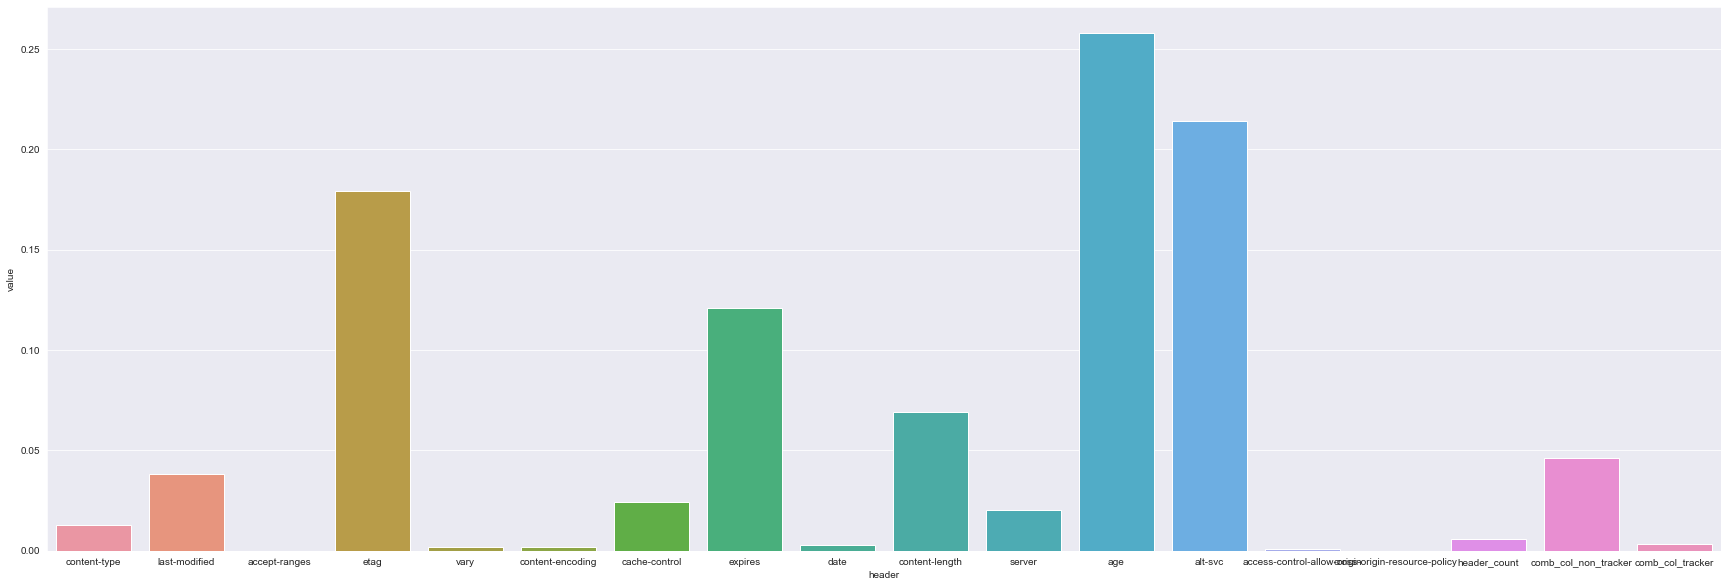

In [210]:
% matplotlib inline
plt.figure(figsize=(30, 10))
sns.barplot(data=pd.DataFrame(d), x="header", y="value")

In [211]:
rf.score(X_test, y_test["tracker"].to_numpy())

0.7815326245202276

In [212]:
clf_probs = rf.predict_proba(X_test)
score = metrics.log_loss(y_test, clf_probs)
print(score)

0.46241354102549004


In [226]:
knn = KNeighborsClassifier(n_jobs=-1)

In [227]:
% % time
knn.fit(X_train_2, y_train["tracker"].to_numpy())

CPU times: user 24.8 ms, sys: 15.5 ms, total: 40.3 ms
Wall time: 39.1 ms


KNeighborsClassifier(n_jobs=-1)

In [228]:
knn.score(X_test, y_test["tracker"].to_numpy())

0.6790341318510021

In [229]:
from sklearn.svm import SVC

In [ ]:
% % time
svm = SVC(kernel="linear")
svm.fit(X_train_2, y_train["tracker"].to_numpy())

In [ ]:
svm.score(X_test, y_test["tracker"].to_numpy())